# Find the Measured Velocities


In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-23"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [51]:
from src.walk_configs import walk_configs


In [52]:
experiment_path = Path(
    "/Users/max/Development/tmp/CarFollowingDefaults/02.06.2023_13.22.43"
)


In [53]:
configs = list(walk_configs(experiment_path))
configs = [config for config in configs if (Path(config.Metadata.cwd) / "summary_df.parquet").exists()]

In [55]:
for config in configs:
    print(config.Metadata.cwd, config.Blocks.CFTableConfig.additional_params.carFollowingModel)

/Users/max/Development/tmp/CarFollowingDefaults/02.06.2023_13.22.43/0 IDM


### Read the File


In [56]:
import pandas as pd


def get_summary_df(config, additional_params: dict = None) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    print(config.Metadata.cwd)
    df = pd.read_parquet(Path(config.Metadata.cwd) / "summary_df.parquet")
    for key, value in additional_params.items():
        df[key] = value
    return df

In [57]:
dfs = []
for config in configs:
    additional_params = {
        "carFollowingModel": config.Blocks.CFTableConfig.additional_params.carFollowingModel,
        "seed": config.Blocks.SeedConfig.seed,
    }

    df = get_summary_df(config, additional_params=additional_params)
    dfs.append(df)
sumo_df = pd.concat(dfs)

/Users/max/Development/tmp/CarFollowingDefaults/02.06.2023_13.22.43/0


## Read the RW Data

In [58]:
rw_df = pd.read_parquet(ROOT / "data" / "rw_east_thru_summary.parquet")

## Plot the Histograms

(0.0, 6.0)

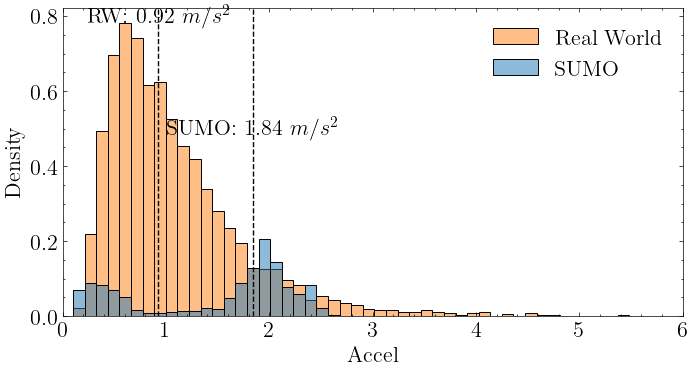

In [62]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use('science')

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({'font.size': 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = sumo_df[(sumo_df["r2"] > 0.9) & (sumo_df['type'] == "accel")]
accel_sumo_df = accel_sumo_df[accel_sumo_df["carFollowingModel"] == "IDM"]

# concatenate the rw data
accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "accel")].copy()
accel_rw_df["carFollowingModel"] = "Real World"

plot_df = pd.concat([accel_sumo_df, accel_rw_df])


sns.histplot(data=plot_df, x="slope", hue="carFollowingModel", stat="density", ax=ax,  palette=["#1f77b4", "#ff7f0e"])
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)
# set the legend labels
ax.legend(labels=["Real World", "SUMO"])
# # add the rw data
# accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "accel")]
# sns.histplot(data=accel_rw_df, x="slope", stat="density", ax=ax)

# add a vertical line at the mean
median_sumo = plot_df.loc[plot_df['carFollowingModel'] == "IDM", "slope"].median()
median_rw = plot_df.loc[plot_df['carFollowingModel'] == "Real World", "slope"].median()
ax.axvline(median_sumo, color="black", linestyle="--")
ax.axvline(median_rw, color="black", linestyle="--")
# add text to the vertical line
ax.text(median_sumo, 0.5, f"SUMO: {median_sumo:.2f} $m/s^2$", rotation=0, va="center", ha="center")
ax.text(median_rw, 0.8, f"RW: {median_rw:.2f} $m/s^2$", rotation=0, va="center", ha="center")



# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(0, 6)
